In [1]:
from pathlib import Path
import pickle

In [2]:
import numpy as np
import pandas as pd

In [3]:
import gpflow
import tensorflow as tf

In [4]:
from gpflow.utilities import print_summary
gpflow.config.set_default_summary_fmt("notebook")

In [5]:
import casadi as cs

In [6]:
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 6)

## GP model

In [8]:
size = 500

In [9]:
X = np.linspace(-2, 2, num = size)
# x^4 + 3*sin(x)
Y =3 * X ** 2

In [10]:
df_func = pd.DataFrame({
    'X': X,
    'Y': Y
})

In [11]:
n_sampl = 15

In [12]:
df_sampled = df_func.sample(n_sampl)
X_sampled = df_sampled['X'].to_numpy().reshape(-1, 1)

In [13]:
Y_sampled = df_sampled['Y'].to_numpy().reshape(-1, 1)

# Add noise to the output
mean, var = 0, 0.5
noise = np.random.normal(mean, var, size = Y_sampled.shape)

Y_sampled = Y_sampled + noise

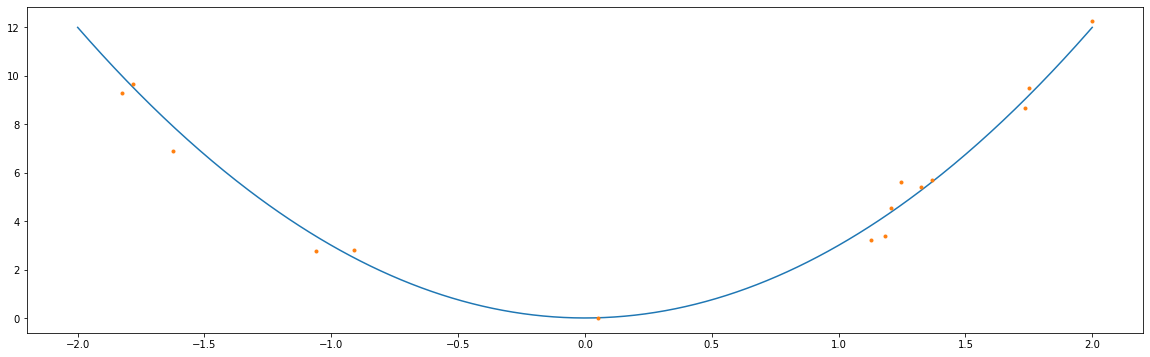

In [14]:
plt.figure()
plt.plot(X, Y)
plt.plot(X_sampled, Y_sampled, '.')
plt.show()

In [15]:
k = gpflow.kernels.SquaredExponential() + gpflow.kernels.Linear()

In [16]:
print_summary(k)

name,class,transform,prior,trainable,shape,dtype,value
Sum.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Sum.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
Sum.kernels[1].variance,Parameter,Softplus,,True,(),float64,1


In [17]:
model = gpflow.models.GPR(
    data = (X_sampled, Y_sampled), 
    kernel = k, 
    mean_function = None
    )
print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1


In [18]:
from datetime import datetime

In [19]:
opt = gpflow.optimizers.Scipy()

In [20]:
start_time = datetime.now()
opt.minimize(model.training_loss, model.trainable_variables)
print(f"Finished fitting in {datetime.now() - start_time}")
print_summary(model)

Finished fitting in 0:00:00.980794


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1031.13
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,3.57915
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,5.2804e-48
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.336471


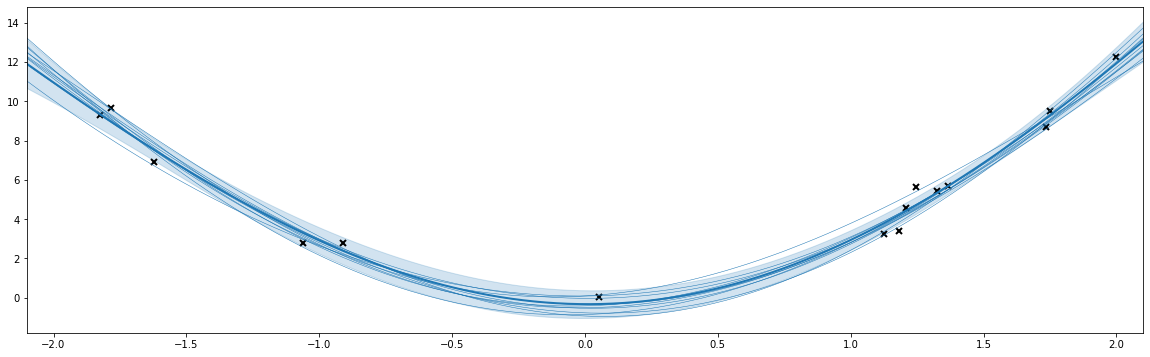

In [21]:
## generate test points for prediction
xx = np.linspace(-2.1, 2.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = model.predict_f(xx)

## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = model.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
plt.figure()
plt.plot(X_sampled, Y_sampled, "kx", mew=2)
plt.plot(xx, mean, "C0", lw=2)
plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)
plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
#plt.plot(X, Y, color = 'darkorange', lw = 2)
_ = plt.xlim(-2.1, 2.1)

## CasADi part

In [22]:
# Package the resulting regression model in a CasADi callback
class GPR(cs.Callback):
  def __init__(self, name,  opts={}):
    cs.Callback.__init__(self)
    self.construct(name, opts)

  def eval(self, arg):
    [mean, _] = model.predict_y(np.array(arg[0]))
    return [mean.numpy()]

In [23]:
# Instantiate the Callback (make sure to keep a reference to it!)
gpr = GPR('GPR', {"enable_fd":True})
print(gpr)

GPR:(i0)->(o0) CallbackInternal


In [37]:
# Find the minimum of the regression model
x = cs.MX.sym("x")
y = 2 * gpr(x) + 5
f = cs.Function('f', [x], [y])

In [43]:
prob = {"x":x,"f":f(x)}
options = {"ipopt": {"hessian_approximation": "limited-memory", "max_iter": 500,
                     "acceptable_tol": 1e-5,
                     #"linear_solver": "SPRAL",
                     "acceptable_obj_change_tol": 1e-3, 
                     #"mu_strategy": "adaptive",
                     #"expect_infeasible_problem": "yes"
                    }}

In [44]:


solver = cs.nlpsol("solver","ipopt",prob, options)
res = solver(lbx = -2, ubx = 2)

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Exception ignored in: <bound method WeakStructRef._cleanup of WeakStructRef(HashableWeakRef(<weakref at 0x7f9723f66090; dead>))>
Traceback (most recent call last):
  File "/usr/lib/python3.9/site-packages/tensorflow_probability/python/internal/cache_util.py", line 153, in _cleanup
    if self._alive:
AttributeError: _alive


 321  4.3557888e+00 0.00e+00 2.37e-05  -9.0 4.25e-07    -  1.00e+00 1.00e+00w  1


CasADi - 2021-04-15 15:16:54 WARNING("solver:nlp_f failed:Error in Function::operator() for 'nlp_f' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'GPR' [CallbackInternal] at .../casadi/core/function.cpp:1368:
.../casadi/core/function_internal.cpp:3366: Failed to evaluate 'eval_dm' for GPR:
.../casadi/core/callback_internal.cpp:122: Error calling "eval" for object GPR:
KeyboardInterrupt") [.../casadi/core/oracle_function.cpp:223]


 322  4.3557888e+00 0.00e+00 1.04e-05  -9.0 3.41e-07    -  1.00e+00 5.68e-14f 44
 323  4.3557888e+00 0.00e+00 1.04e-05  -9.0 1.49e-07    -  1.00e+00 3.64e-12f 39
 324  4.3557888e+00 0.00e+00 1.04e-05  -9.0 1.49e-07    -  1.00e+00 3.64e-12f 39
 325  4.3557888e+00 0.00e+00 1.04e-05  -9.0 1.04e-05    -  1.00e+00 5.68e-14f 45
 326  4.3557888e+00 0.00e+00 1.04e-05  -9.0 1.04e-05    -  1.00e+00 5.68e-14f 45
 327  4.3557888e+00 0.00e+00 1.04e-05  -9.0 1.04e-05    -  1.00e+00 5.68e-14f 45
 328  4.3557888e+00 0.00e+00 1.04e-05  -9.0 1.04e-05    -  1.00e+00 5.68e-14f 45
 329  4.3557888e+00 0.00e+00 1.04e-05  -9.0 1.04e-05    -  1.00e+00 5.68e-14f 45
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330  4.3557888e+00 0.00e+00 1.04e-05  -9.0 1.04e-05    -  1.00e+00 5.68e-14f 45
 331  4.3557888e+00 0.00e+00 1.04e-05  -9.0 1.04e-05    -  1.00e+00 5.68e-14f 45
 332  4.3557888e+00 0.00e+00 1.36e-04  -9.0 1.04e-05    -  1.00e+00 1.00e+00w  1
 333  4.3557888e+00 0.00e+00

CasADi - 2021-04-15 15:17:28 WARNING("solver:nlp_f failed:Error in Function::operator() for 'nlp_f' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'GPR' [CallbackInternal] at .../casadi/core/function.cpp:1368:
.../casadi/core/function_internal.cpp:3366: Failed to evaluate 'eval_dm' for GPR:
.../casadi/core/callback_internal.cpp:122: Error calling "eval" for object GPR:
KeyboardInterrupt") [.../casadi/core/oracle_function.cpp:223]
Exception ignored in: <bound method WeakStructRef._cleanup of WeakStructRef(HashableWeakRef(<weakref at 0x7f97236725e0; dead>))>
Traceback (most recent call last):
  File "/usr/lib/python3.9/site-packages/tensorflow_probability/python/internal/cache_util.py", line 153, in _cleanup
    if self._alive:
AttributeError: _alive
CasADi - 2021-04-15 15:17:28 WARNING("solver:nlp_f failed:Error in Function::operator() for 'nlp_f' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'GPR' [CallbackInt

 401  4.3557888e+00 0.00e+00 1.04e-05  -9.0 1.49e-07    -  1.00e+00 3.64e-12f 39
 402  4.3557888e+00 0.00e+00 1.04e-05  -9.0 1.49e-07    -  1.00e+00 3.64e-12f 39
 403  4.3557888e+00 0.00e+00 1.04e-05  -9.0 1.04e-05    -  1.00e+00 5.68e-14f 45
 404  4.3557888e+00 0.00e+00 1.04e-05  -9.0 1.04e-05    -  1.00e+00 5.68e-14f 45
 405  4.3557888e+00 0.00e+00 1.04e-05  -9.0 1.04e-05    -  1.00e+00 5.68e-14f 45
 406  4.3557888e+00 0.00e+00 1.04e-05  -9.0 1.04e-05    -  1.00e+00 5.68e-14f 45


CasADi - 2021-04-15 15:17:31 WARNING("solver:nlp_f failed:Error in Function::operator() for 'nlp_f' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'GPR' [CallbackInternal] at .../casadi/core/function.cpp:1368:
.../casadi/core/function_internal.cpp:3366: Failed to evaluate 'eval_dm' for GPR:
.../casadi/core/callback_internal.cpp:122: Error calling "eval" for object GPR:
KeyboardInterrupt") [.../casadi/core/oracle_function.cpp:223]
Exception ignored in: <bound method WeakStructRef._cleanup of WeakStructRef(HashableWeakRef(<weakref at 0x7f9723545770; dead>))>
Traceback (most recent call last):
  File "/usr/lib/python3.9/site-packages/tensorflow_probability/python/internal/cache_util.py", line 153, in _cleanup
    if self._alive:
AttributeError: _alive
CasADi - 2021-04-15 15:17:31 WARNING("solver:nlp_f failed:Error in Function::operator() for 'nlp_f' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'GPR' [CallbackInt

Exception ignored in: <bound method WeakStructRef._cleanup of WeakStructRef(HashableWeakRef(<weakref at 0x7f9723559720; dead>))>
Traceback (most recent call last):
  File "/usr/lib/python3.9/site-packages/tensorflow_probability/python/internal/cache_util.py", line 153, in _cleanup
    if self._alive:
AttributeError: _alive


 407  4.3557888e+00 0.00e+00 1.04e-05  -9.0 1.04e-05    -  1.00e+00 5.68e-14f 45


CasADi - 2021-04-15 15:17:31 WARNING("solver:nlp_f failed:Error in Function::operator() for 'nlp_f' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'GPR' [CallbackInternal] at .../casadi/core/function.cpp:1368:
.../casadi/core/function_internal.cpp:3366: Failed to evaluate 'eval_dm' for GPR:
.../casadi/core/callback_internal.cpp:122: Error calling "eval" for object GPR:
KeyboardInterrupt") [.../casadi/core/oracle_function.cpp:223]
CasADi - 2021-04-15 15:17:32 WARNING("solver:nlp_f failed:Error in Function::operator() for 'nlp_f' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'GPR' [CallbackInternal] at .../casadi/core/function.cpp:1368:
.../casadi/core/function_internal.cpp:3366: Failed to evaluate 'eval_dm' for GPR:
.../casadi/core/callback_internal.cpp:122: Error calling "eval" for object GPR:
KeyboardInterrupt") [.../casadi/core/oracle_function.cpp:223]


 408  4.3557888e+00 0.00e+00 1.04e-05  -9.0 1.04e-05    -  1.00e+00 5.68e-14f 45


CasADi - 2021-04-15 15:17:32 WARNING("solver:nlp_f failed:Error in Function::operator() for 'nlp_f' [MXFunction] at .../casadi/core/function.cpp:1368:
Error in Function::operator() for 'GPR' [CallbackInternal] at .../casadi/core/function.cpp:1368:
.../casadi/core/function_internal.cpp:3366: Failed to evaluate 'eval_dm' for GPR:
.../casadi/core/callback_internal.cpp:122: Error calling "eval" for object GPR:
KeyboardInterrupt") [.../casadi/core/oracle_function.cpp:223]


 409  4.3557888e+00 0.00e+00 1.04e-05  -9.0 1.04e-05    -  1.00e+00 5.68e-14f 45
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410  4.3557888e+00 0.00e+00 1.36e-04  -9.0 1.04e-05    -  1.00e+00 1.00e+00w  1
 411  4.3557888e+00 0.00e+00 5.77e-06  -9.0 9.62e-06    -  1.00e+00 1.00e+00w  1
 412  4.3557888e+00 0.00e+00 2.37e-05  -9.0 4.25e-07    -  1.00e+00 1.00e+00w  1
 413  4.3557888e+00 0.00e+00 1.04e-05  -9.0 3.41e-07    -  1.00e+00 5.68e-14f 44
 414  4.3557888e+00 0.00e+00 1.04e-05  -9.0 1.49e-07    -  1.00e+00 3.64e-12f 39
 415  4.3557888e+00 0.00e+00 1.04e-05  -9.0 1.49e-07    -  1.00e+00 3.64e-12f 39
 416  4.3557888e+00 0.00e+00 1.04e-05  -9.0 1.04e-05    -  1.00e+00 5.68e-14f 45
 417  4.3557888e+00 0.00e+00 1.04e-05  -9.0 1.04e-05    -  1.00e+00 5.68e-14f 45
Exception of type: IpoptException in file "Unknown File" at line -1:
 Exception message: Unknown Exception caught in Ipopt
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
 

In [40]:
res['x']

DM(0.0112358)

In [41]:
res['f']

DM(4.35579)